In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import uniform
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier as xgb

In [16]:
df_train = pd.read_csv("../Data/Logs_Trans_Mem_Train_Data_minus_one_impute.csv" )
df_train.head()

,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,discount,is_discount,amt_per_day,...,notautorenew_&_cancel,city,bd,gender,total_secs,num_25,num_50,num_75,num_100,num_unq
0,1.0,38.0,30.0,149.0,149.0,0.0,0.0,0.0,0.0,4.966667,...,0.0,13.0,28.0,0.0,3866.322,0.0,0.5,0.0,17.0,13.5
1,1.0,38.0,30.0,149.0,149.0,0.0,0.0,0.0,0.0,4.966667,...,0.0,13.0,28.0,0.0,4622.813,1.0,1.0,0.0,9.0,8.0
2,1.0,38.0,120.0,596.0,596.0,0.0,0.0,0.0,0.0,4.966667,...,0.0,14.0,29.0,1.0,7805.604,3.0,1.0,0.0,30.0,39.0
3,1.0,38.0,410.0,1788.0,1788.0,0.0,0.0,0.0,0.0,4.360976,...,0.0,6.0,41.0,1.0,2952.226,1.0,0.0,0.0,12.0,6.0
4,1.0,38.0,30.0,149.0,149.0,0.0,0.0,0.0,0.0,4.966667,...,0.0,9.0,18.0,0.0,4480.687,1.0,1.0,1.0,16.0,14.0


In [17]:
## Note Use Data From The following Csv File Logs_Trans_Mem_Train_Data_minus_one_impute.csv
## just do this change df_train = pd.read_csv("../Data/Logs_Trans_Mem_Train_Data_minus_one_impute.csv" )
train_cols  = [c for c in df_train.columns if c not in ['is_churn']]
X_train = df_train[train_cols]
y_train = df_train['is_churn']
y_train.value_counts()
### Splitt Trainn and Test Data 
## Pre Processing
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X_train , y_train , test_size = 0.20 , random_state = 43)
print(X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = StandardScaler().fit_transform(X_train)
X_test =  StandardScaler().fit_transform(X_test)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

(746861, 21) (186716, 21)
(746861,) (186716,)


In [18]:
def plot_scores_hist(model , index , columns , values):
    
    pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values=values, index=index, columns=columns)
#pvt
    ax = sns.heatmap(pvt,annot=True)

In [19]:
def plot_conf_matrix(y_test , y_pred):
    C= confusion_matrix(y_test , y_pred )
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    labels = [0,1]
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [20]:
def plot_auc_roc(model,X_test , y_test):
    # plotting Roc curve
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
def save_file(model , filename):
    joblib.dump(model, open(filename, 'wb'))


# 1 .Linear Models:

## Logistic Regression with GridSearch Cv

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
lr = LogisticRegression(class_weight = 'balanced' , solver = 'saga' ,C = 0.003)
lr.fit(X_train , y_train)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.003, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [9]:
filename = "Log_reg_final.sav"
save_file(lr, filename)

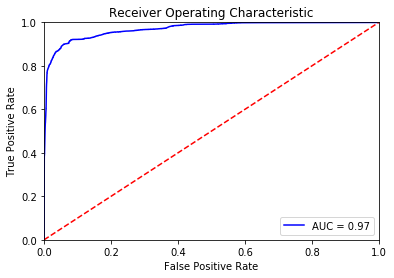

In [11]:
plot_auc_roc(lr,X_test,y_test)

-------------------- Confusion matrix --------------------


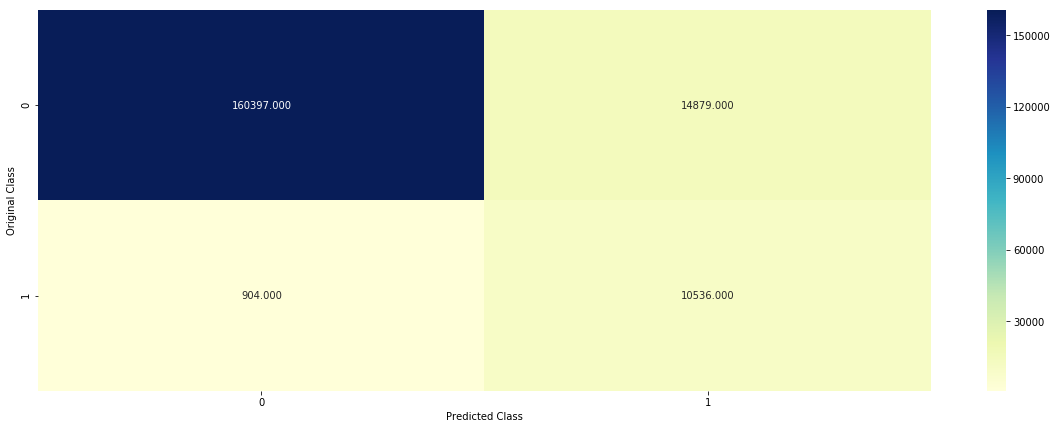

In [13]:
y_pred = lr.predict(X_test)
plot_conf_matrix(y_test,y_pred)



### Observations :
1. Almost 10k Churned Users accurately Predicted on The Test Set , 904 churned users missclassified as non churned users
2. Almost 160 k Non Churned users classified accurately , 14 k missclassified
3. Roc of 0.97 quite good for Logistic Regression Model

### Feature Importance

In [22]:
perm = PermutationImportance(lr, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(train_cols))


Weight,Feature
0.0329 ± 0.0003,is_cancel
0.0321 ± 0.0004,membership_duration
0.0118 ± 0.0002,payment_plan_days
0.0017 ± 0.0001,discount
0.0005 ± 0.0000,is_discount
0.0002 ± 0.0001,num_100
0.0001 ± 0.0001,city
0.0001 ± 0.0001,num_75
0.0001 ± 0.0000,bd
0.0000 ± 0.0001,num_25


## 2. Decision Tree Classifier

In [23]:
dtree = DecisionTreeClassifier(class_weight='balanced' , max_depth= 10 , min_samples_split=500)
dtree.fit(X_train , y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

-------------------- Confusion matrix --------------------


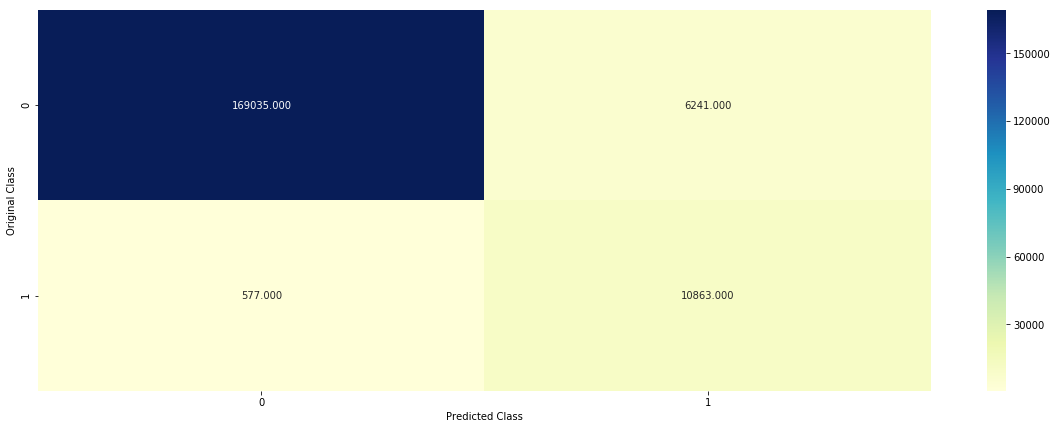

In [24]:
y_pred = dtree.predict(X_test)
plot_conf_matrix(y_test,y_pred)



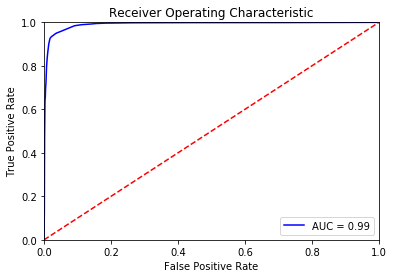

In [25]:
plot_auc_roc(dtree , X_test , y_test)

#### Observations:
1. The Auc Score Improved from 0.97 to 0.99 , Which is Significant Improvement over Logistic Regression Model
2. Also The Perfomance on Churned Users Improved Earlier we were miss classifying 900 Churned users this time we have missclassified only 577 Churned Users.
3. For Non Churned Users Also , We were Earlier Able to Classify only 160 k Non Churned Users Correctly , This Time we are able to classify 169k Non Churned Users
4. This Happens As Decision Trees Are Also able to Capture non linear Relationships which exists in Data which are not captured by Logistic Regression till we do Explicit Feature Engineering

In [28]:
perm = PermutationImportance(dtree).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(train_cols))


Weight,Feature
0.1056 ± 0.0008,notautorenew_&_cancel
0.0806 ± 0.0006,membership_duration
0.0481 ± 0.0002,is_auto_renew
0.0246 ± 0.0006,amt_per_day
0.0007 ± 0.0001,actual_amount_paid
0.0003 ± 0.0001,num_unq
0.0001 ± 0.0000,plan_list_price
0.0001 ± 0.0001,num_100
0.0000 ± 0.0000,discount
0.0000 ± 0.0000,num_50


### 3. Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500 , max_depth = None  ,  n_jobs =  3 , verbose =2)
rf.fit(X_train , y_train )


building tree 1 of 500building tree 2 of 500building tree 3 of 500


building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   40.9s


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.0min


building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500


[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  6.8min


building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500


[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.2s finished


-------------------- Confusion matrix --------------------


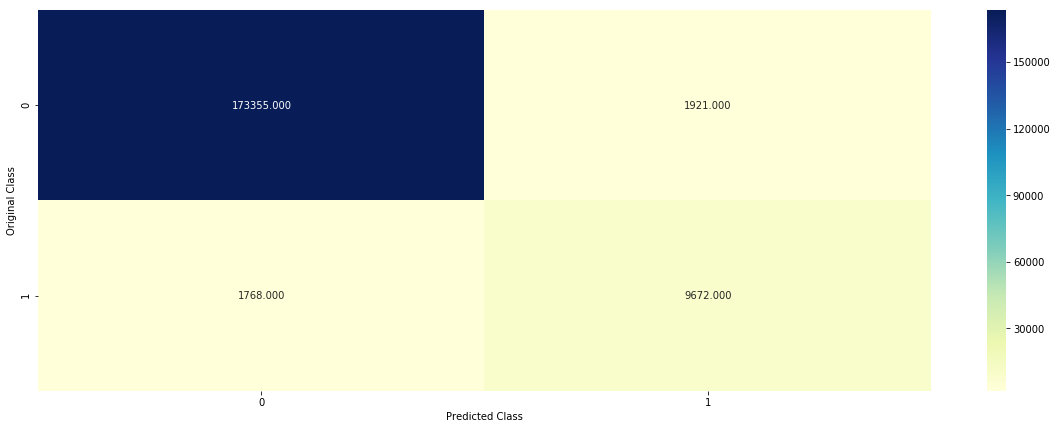

In [33]:
filename ="Random_Forest_Logs_Mem_Final.sav"
save_file(rf , filename)
y_pred = rf.predict(X_test)
plot_conf_matrix(y_test,y_pred)



[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.2s finished


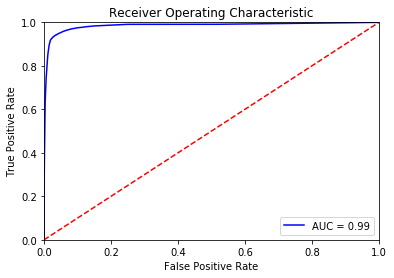

In [34]:
plot_auc_roc(rf,X_test,y_test)

1. Auc remained same , but missclassification increased on churned users.
2. Lets Increase number of base learners to see if perfomance improves or not.
3. If not we will also tune min_samples split and max_depth a bit

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000 , max_depth = None   ,  n_jobs =  3 , verbose =2)
rf.fit(X_train , y_train )


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000


building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   44.4s


building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.5min


building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tre

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  7.9min


building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tre

[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 14.1min


building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tre

building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tre

[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 21.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   11.2s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:   16.7s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.8s finished


-------------------- Confusion matrix --------------------


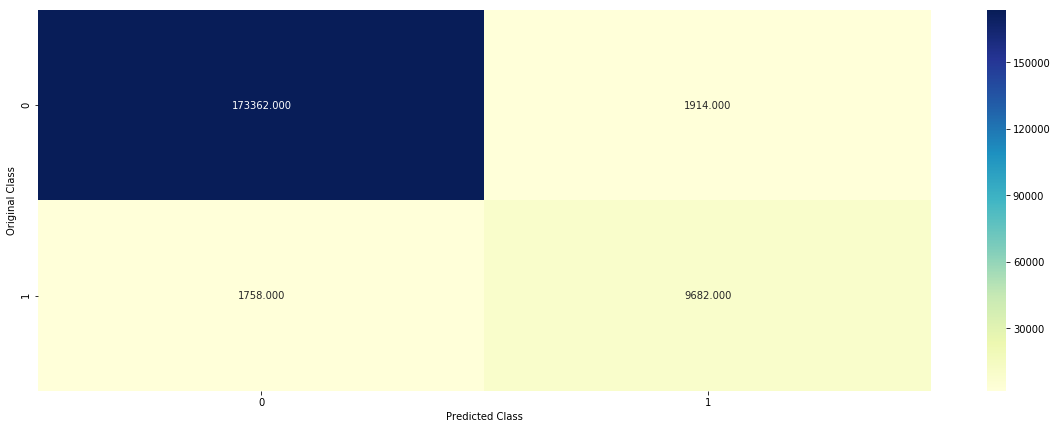

In [36]:
filename ="Random_Forest_Logs_Mem_Final_1000.sav"
save_file(rf , filename)
y_pred = rf.predict(X_test)
plot_conf_matrix(y_test,y_pred)



#### We can use GridSearch Cv to Tune Min_samples_split to achieve better performance on Churned Users 
#### However Auc is still 0.99 which is good 

## 4. Xgboost Classifier

In [42]:
xgboost_model = xgb(n_estimators = 200 , learning_rate = 0.1 , max_depth = 50 , verbosity = 2 , n_jobs = 3)
xgboost_model.fit(X_train,y_train)

[15:15:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4604 extra nodes, 0 pruned nodes, max_depth=39
[15:15:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4224 extra nodes, 0 pruned nodes, max_depth=40
[15:15:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4392 extra nodes, 0 pruned nodes, max_depth=39
[15:15:18] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4604 extra nodes, 0 pruned nodes, max_depth=49
[15:15:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4888 extra nodes, 0 pruned nodes, max_depth=45
[15:15:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 507

[15:23:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6944 extra nodes, 0 pruned nodes, max_depth=50
[15:23:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6022 extra nodes, 0 pruned nodes, max_depth=50
[15:23:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 5316 extra nodes, 0 pruned nodes, max_depth=50
[15:23:33] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6188 extra nodes, 0 pruned nodes, max_depth=50
[15:23:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 6422 extra nodes, 0 pruned nodes, max_depth=50
[15:23:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 542

[15:30:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 3682 extra nodes, 0 pruned nodes, max_depth=50
[15:30:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2830 extra nodes, 0 pruned nodes, max_depth=50
[15:30:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4046 extra nodes, 0 pruned nodes, max_depth=50
[15:30:38] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2254 extra nodes, 0 pruned nodes, max_depth=50
[15:30:47] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4828 extra nodes, 0 pruned nodes, max_depth=50
[15:30:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 365

[15:36:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 3926 extra nodes, 0 pruned nodes, max_depth=50
[15:36:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2822 extra nodes, 0 pruned nodes, max_depth=50
[15:36:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 3872 extra nodes, 0 pruned nodes, max_depth=50
[15:36:34] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 3444 extra nodes, 0 pruned nodes, max_depth=50
[15:36:42] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 4376 extra nodes, 0 pruned nodes, max_depth=50
[15:36:50] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 400

[15:41:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 1716 extra nodes, 0 pruned nodes, max_depth=50
[15:42:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 1968 extra nodes, 0 pruned nodes, max_depth=50
[15:42:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2202 extra nodes, 0 pruned nodes, max_depth=50
[15:42:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 2878 extra nodes, 0 pruned nodes, max_depth=50
[15:42:22] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 926 extra nodes, 0 pruned nodes, max_depth=50
[15:42:30] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 1962

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=50,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=200, n_jobs=3, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=2)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


-------------------- Confusion matrix --------------------


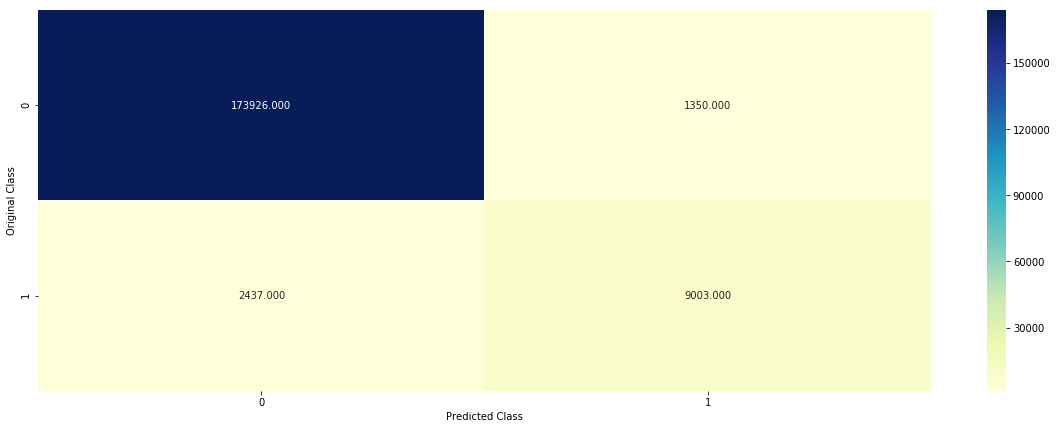

In [43]:
filename ="Xgboost_Logs_Mem_trans_final.sav"
save_file(xgboost_model , filename)
y_pred = xgboost_model.predict(X_test)
plot_conf_matrix(y_test,y_pred)



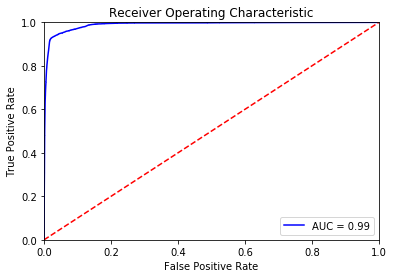

In [44]:
plot_auc_roc(xgboost_model,X_test,y_test)

### Learning:
1. Xgboost Can Perform Better But requires proper Hyperparams Tuning using cross validation
2. In Our Blog We will Explain Intuition Behind all these models and also results

## Conclusions:

<table>
    <tr>
    <th>Sr.No</th>
    <th> Model </th>    
    <th> Hyperparameters </th>
    <th>Test AUC-ROC</th>    
    </tr>
    <tr>
    <td> 1 </td>
    <td>Logistic Regresion</td>
    <td>alpha =0.003 with L2 regularization</td>
    <td> 0.97 </td>
    </tr>
    <tr>
     <td> 2 </td>
    <td>Decision Tree Classifier</td>
    <td>min_samples_split = 500  and Max Depth =10</td>
    <td>0.99</td>
    </tr>
    <tr>
     <td> 3 </td>
    <td>Random Forests  Classifier</td>
    <td>n_estimators = 500  and Max Depth = None</td>
    <td>0.99</td>
    </tr>  
    <tr>
    <td> 4</td>
    <td>Xgboost</td>
    <td>n_estimator = 200 , learning_rate = 0.1 , max_depth = 50</td>
    <td>0.99</td>
    
    </tr>
 </table>